
# Advanced Machine Learning
**Dataset:** `palmerpenguins.csv`  
**Task:** Multiclass classification (species)


In [33]:

import os, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.keras.utils.set_random_seed(SEED)

CSV_CANDIDATES = ["palmerpenguins.csv","/content/palmerpenguins.csv"]
CSV_PATH = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
assert CSV_PATH is not None, "Place palmerpenguins.csv next to this notebook."
CSV_PATH


'palmerpenguins.csv'

## 1) Load data

Loaded: (344, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


After removing NaN in target: (344, 8)


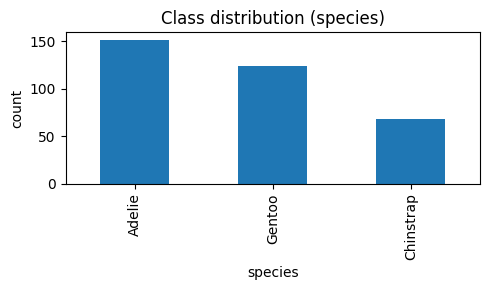

Missing per column:
 sex                  11
bill_depth_mm         2
flipper_length_mm     2
bill_length_mm        2
body_mass_g           2
island                0
species               0
year                  0
dtype: int64


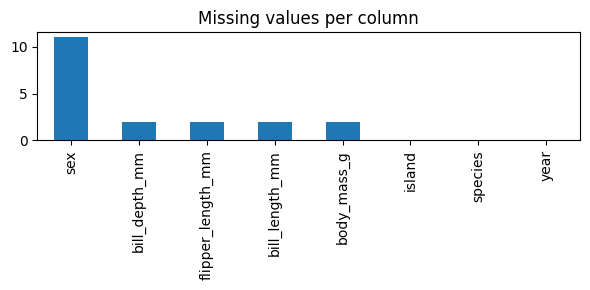

In [34]:

df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
display(df.head())

# Drop rows with missing target
df = df[~df["species"].isna()].copy()
print("After removing NaN in target:", df.shape)

# Class balance
ax = df["species"].value_counts().plot(kind="bar", figsize=(5,3), title="Class distribution (species)")
ax.set_xlabel("species"); ax.set_ylabel("count"); plt.tight_layout(); plt.show()

# Missing values per column
na_counts = df.isna().sum().sort_values(ascending=False)
print("Missing per column:\n", na_counts)
na_counts.plot(kind="bar", figsize=(6,3), title="Missing values per column"); plt.tight_layout(); plt.show()


## 2) Preprocessing

In [35]:
num_cols = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "year"]
cat_cols = ["island", "sex"]

X = df[num_cols + cat_cols].copy()
y = df["species"].copy()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    [("num", num_pipe, num_cols),
     ("cat", cat_pipe, cat_cols)],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

X_train_proc = preprocess.fit_transform(X_train)
X_test_proc  = preprocess.transform(X_test)

# Encode labels to indices
class_names = sorted(y.unique())
class_to_idx = {c:i for i,c in enumerate(class_names)}
y_train_idx = y_train.map(class_to_idx).values
y_test_idx  = y_test.map(class_to_idx).values

n_features = X_train_proc.shape[1]
n_classes = len(class_names)

print("Shapes:", X_train_proc.shape, X_test_proc.shape, "classes:", class_names)


Shapes: (275, 10) (69, 10) classes: ['Adelie', 'Chinstrap', 'Gentoo']


## 3–4) Deep Learning architecture & Training

Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_330 (Dense)               │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,883 (11.26 KB)

 Trainable params: 2,883 (11.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4701 - loss: 1.0559 - val_accuracy: 0.8545 - val_loss: 0.8149
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8913 - loss: 0.7549 - val_accuracy: 0.8000 - val_loss: 0.6127
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8999 - loss: 0.5498 - val_accuracy: 0.8545 - val_loss: 0.4390
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9326 - loss: 0.3717 - val_accuracy: 0.9273 - val_loss: 0.3018
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9477 - loss: 0.2468 - val_accuracy: 1.0000 - val_loss: 0.2012
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9628 - loss: 0.1821 - val_accuracy: 1.0000 - val_loss: 0.1346
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9704 - loss: 0.1379 - val_accuracy: 1.0000 - val_loss: 0.0923
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9836 - loss: 0.0994 - val_accuracy: 1.0000 - 

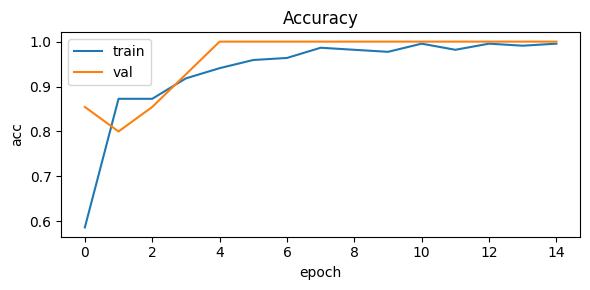

Baseline test accuracy: 0.9855


In [36]:

def build_mlp(n_features, n_classes):
    model = keras.Sequential([
        keras.Input(shape=(n_features,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

baseline = build_mlp(n_features, n_classes)
baseline.summary()

early = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

hist = baseline.fit(
    X_train_proc, y_train_idx,
    validation_split=0.2,
    epochs=150,
    batch_size=16,
    callbacks=[early],
    verbose=1
)

plt.figure(figsize=(6,3))
plt.plot(hist.history["accuracy"], label="train")
plt.plot(hist.history["val_accuracy"], label="val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend(); plt.tight_layout(); plt.show()

test_loss, test_acc = baseline.evaluate(X_test_proc, y_test_idx, verbose=0)
print(f"Baseline test accuracy: {test_acc:.4f}")


## 5) Hyperparameter tuning (Random Search)

Best config: {'units1': 32, 'units2': 96, 'dropout': 0.3, 'l2': 0.0001, 'lr': 0.0005, 'batch': 32, 'opt': np.str_('adam')} val_acc= 1.0


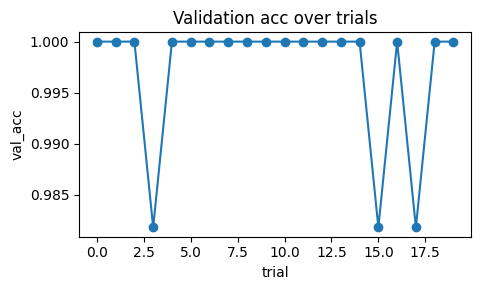

Best-model test accuracy: 0.9710


In [37]:

def build_cfg_model(n_features, n_classes, units1, units2, dropout, l2val, lr, opt_name="adam"):
    model = keras.Sequential([
        keras.Input(shape=(n_features,)),
        layers.Dense(units1, activation="relu", kernel_regularizer=regularizers.l2(l2val)),
        layers.Dropout(dropout),
        layers.Dense(units2, activation="relu", kernel_regularizer=regularizers.l2(l2val)),
        layers.Dense(n_classes, activation="softmax")
    ])
    opt = keras.optimizers.Adam(lr) if opt_name=="adam" else keras.optimizers.RMSprop(lr)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

search_space = {
    "units1":  [32,64, 128, 192, 256],
    "units2":  [16,32, 64, 96, 128],
    "dropout": [0.0, 0.2, 0.3, 0.5],
    "l2":      [1e-5, 1e-4, 1e-3],
    "lr":      [1e-3, 5e-4, 2e-3],
    "batch":   [8, 16, 32],
    "opt":     ["adam", "rmsprop"]
}

rng = np.random.default_rng(SEED)
def sample(space, n=20):
    keys = list(space.keys())
    for _ in range(n):
        cfg = {k: rng.choice(v).item() if isinstance(v[0], (int,float)) else rng.choice(v) for k,v in space.items()}
        yield cfg

best = {"val_acc": -1, "cfg": None, "model": None}
val_scores = []

for i, cfg in enumerate(sample(search_space, n=20)):
    model = build_cfg_model(n_features, n_classes, cfg["units1"], cfg["units2"],
                            cfg["dropout"], cfg["l2"], cfg["lr"], cfg["opt"])
    early = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8, restore_best_weights=True)
    h = model.fit(
        X_train_proc, y_train_idx,
        validation_split=0.2,
        epochs=150,
        batch_size=int(cfg["batch"]),
        callbacks=[early],
        verbose=0
    )
    v = max(h.history["val_accuracy"])
    val_scores.append(v)
    if v > best["val_acc"]:
        best = {"val_acc": v, "cfg": cfg, "model": model}

print("Best config:", best["cfg"], "val_acc=", round(best["val_acc"], 4))

plt.figure(figsize=(5,3)); plt.plot(val_scores, marker="o"); plt.title("Validation acc over trials"); plt.xlabel("trial"); plt.ylabel("val_acc"); plt.tight_layout(); plt.show()

best_test_loss, best_test_acc = best["model"].evaluate(X_test_proc, y_test_idx, verbose=0)
print(f"Best-model test accuracy: {best_test_acc:.4f}")


## 6) Evaluation experiments

Confusion matrix:
 [[30  0  0]
 [ 2 12  0]
 [ 0  0 25]]


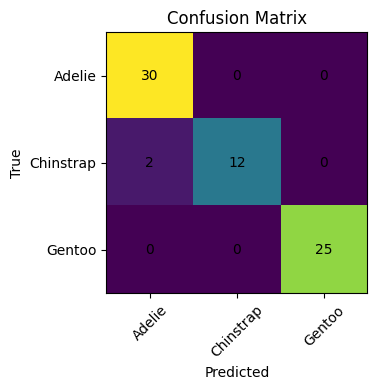

              precision    recall  f1-score   support

      Adelie       0.94      1.00      0.97        30
   Chinstrap       1.00      0.86      0.92        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.97        69
   macro avg       0.98      0.95      0.96        69
weighted avg       0.97      0.97      0.97        69

OVR ROC-AUC: 0.9979


In [38]:

final_model = best["model"] if best["model"] is not None else baseline

# Confusion matrix
y_pred_idx = np.argmax(final_model.predict(X_test_proc, verbose=0), axis=1)
cm = confusion_matrix(y_test_idx, y_pred_idx)
print("Confusion matrix:\n", cm)

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks(range(n_classes), class_names, rotation=45)
plt.yticks(range(n_classes), class_names)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

print(classification_report(y_test_idx, y_pred_idx, target_names=class_names))

# ROC-AUC
try:
    y_test_bin = label_binarize(y_test_idx, classes=list(range(n_classes)))
    y_proba = final_model.predict(X_test_proc, verbose=0)
    auc = roc_auc_score(y_test_bin, y_proba, multi_class="ovr")
    print(f"OVR ROC-AUC: {auc:.4f}")
except Exception as e:
    print("ROC-AUC not computed:", e)
